<a href="https://colab.research.google.com/github/samkirwanppb/UCDPA_SamKirwan/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
##importing all packages needed for this project
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid") ### might have to put this into the function below. we will see in time. 
sns.color_palette("Spectral", as_cmap=True) #this changes the relplot, hue is different in the lm plot
sns.set()

# Data Gathering/Cleaning

In [156]:
##the ratings data set contains the current ratings of all horses trained in Great Britain
ratings = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/ratings.csv')
ratings = ratings.iloc[:, :-7] 
ratings['rating_final'] = ratings[['Flat rating', 'AWT rating']].max(axis = 1) #gets the max rating of the 2 available ratings for a horse and creats and new column
ratings.loc[ratings['Flat rating'].notnull() & ratings['AWT rating'].notnull()].head() #the column on the right contains the max of the 2 columns that we are interested in.

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,Diff AWT,rating_final
34,ABOVE (FR),2017,GELDING,ANJAAL (GB),BROKEN APPLAUSE (IRE),Stuart Williams,89.0,NaN,NaN,94.0,NaN,94.0
155,AIR RAID (GB),2015,GELDING,RAVEN'S PASS (USA),SIREN SOUND (GB),NaN,94.0,NaN,NaN,89.0,NaN,94.0
182,AL KOUT (GB),2014,GELDING,OASIS DREAM (GB),HONORLINA (FR),NaN,61.0,NaN,NaN,67.0,NaN,67.0
196,AL ZARAQAAN (GB),2017,GELDING,GOLDEN HORN (GB),ASHEERAH (GB),Archie Watson,87.0,NaN,NaN,102.0,NaN,102.0
204,ALBA DEL SOLE (IRE),2015,FILLY,DANDY MAN (IRE),WINTERWELL (USA),NaN,49.0,NaN,NaN,42.0,NaN,49.0


In [157]:
ratings = ratings.drop(columns = {'Diff Flat', 'Flat Clltrl', 'Diff AWT', 'Flat rating', 'AWT rating'}) #removing unwanted columns
ratings.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0


In [158]:
###will use the above data to see how many horses a particular trainer has in training. this metric will also be used to predict horse ability. 
trainer = pd.DataFrame()

trainer = ratings.groupby('Trainer')['Name'].count().rename('trainer_horses').reset_index()
trainer.head()

,Trainer,trainer_horses
0,A C Wilson,1
1,A. B. Leyshon,2
2,Adam Nicol,8
3,Adam West,25
4,Adrian Keatley,19


In [159]:
ratings_trainer = ratings.merge(trainer, on = 'Trainer', how = 'left')
ratings_trainer.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN,69.0
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN,90.0
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN


In [160]:
##performance_ratings will be used to see if a horse has had 1,2,3,4,5 or 6+ runs
performance_figures = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/performance_figures.csv')
##remove National Hunt ratings. #meh will come back to it, not sure will I need this table really. 
performance_figures.head()

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,T:73,T:79,T:72,T:63,T:74,T:80
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,A:42,T:47,T:x,T:x,T:x,-
2,A DEFINITE GETAWAY (IRE),2018,GELDING,Ben Pauling,H:x,H:x,H:x,-,-,-
3,A DIFFERENT KIND (IRE),2017,GELDING,Donald McCain,H:93,H:135,H:x,H:x,H:x,H:x
4,A E HOUSMAN (GB),2019,COLT,NaN,T:71,A:x,A:x,T:x,T:x,-


In [161]:
##this function is used to remove the unwanted charactors from the df.
def clean_peformance_figures(data, column):  
  data = data[~data[column].str.contains("H")]
  data = data[~data[column].str.contains("S")]
  data = data[~data[column].str.contains("N")]
  data[column] = data[column].str.replace(":","").str.replace("T", "").str.replace("A","")
  return data

#this for loop iterates through the last 6 columns of the data and passes them into the function created to clean the columns.
for i in performance_figures.columns[-6:]:
  performance_figures = clean_peformance_figures(performance_figures, i)

performance_figures = performance_figures.replace("-", np.nan)
performance_figures['runs'] = 6 - performance_figures.iloc[:,-6:].isna().sum(axis = 1)
performance_figures.head() #we havce succesfully created the runs column which will be used in the model. 

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,73,79,72,63,74,80,6
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,42,47,x,x,x,NaN,5
4,A E HOUSMAN (GB),2019,COLT,NaN,71,x,x,x,x,NaN,5
5,A LA FRANCAISE (GB),2019,FILLY,Jim Goldie,61,71,65,61,50,63,6
6,A LADY FOREVER (GB),2019,FILLY,Robyn Brisland,x,x,x,x,NaN,NaN,4


In [162]:
##I have merged ratings and the columns I want from peformance figures here
ratings_merged = ratings_trainer.merge(performance_figures[['Racehorse', 'runs']], left_on = 'Name', right_on = 'Racehorse').drop(columns = 'Racehorse')
ratings_merged.loc[(~ratings_merged['rating_final'].isna()) & (ratings_merged['runs'] <= 2), 'runs'] = np.nan ##this removes funny examples where horses where imported into GB already with a rating
ratings_merged.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0


In [163]:
yearling_sales = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales.csv').drop(columns = 'Purchaser')
yearling_sales.head()

,Year Foaled,Sire,Dam,Sex,Consignor,Price (€),Price (£),Price (gns)
0,2020.0,Lope de Vega (IRE),Ebeyina (IRE),Colt,Ballylinch Stud,130000.0,NaN,NaN
1,2020.0,U S Navy Flag (USA),Edelline (IRE),Colt,Lynn Lodge Stud,36000.0,NaN,NaN
2,2020.0,Holy Roman Emperor (IRE),Elaysa (GB),Colt,Redpender Stud,90000.0,NaN,NaN
3,2020.0,No Nay Never (USA),Eldalil (GB),Filly,Oaks Farm Stables,85000.0,NaN,NaN
4,2020.0,Churchill (IRE),Elizabelle (IRE),Filly,Baroda Stud,60000.0,NaN,NaN


In [164]:
#Data cleansing to merge into the main dataframe
yearling_sales['Sire'] = yearling_sales['Sire'].str.upper()
yearling_sales['Dam'] = yearling_sales['Dam'].str.upper()
yearling_sales['Sex'] = yearling_sales['Sex'].str.upper()
yearling_sales = yearling_sales.dropna(subset = ['Year Foaled'])
yearling_sales['Year Foaled'] = yearling_sales['Year Foaled'].astype(int)

##going to get them all in the one currency
yearling_sales.loc[~yearling_sales['Price (€)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (€)'].isna()]['Price (€)'] * 0.88
yearling_sales.loc[~yearling_sales['Price (gns)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (gns)'].isna()]['Price (gns)'] * 1.05
yearling_sales.loc[~yearling_sales['Price (£)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (£)'].isna()]['Price (£)'] * 1
yearling_sales = yearling_sales.drop(columns = ['Price (€)', 'Price (£)', 'Price (gns)'])
yearling_sales.head()

<ipython-input-164-b8f1f41d6b38>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearling_sales['Year Foaled'] = yearling_sales['Year Foaled'].astype(int)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,Year Foaled,Sire,Dam,Sex,Consignor,final_sale_price
0,2020,LOPE DE VEGA (IRE),EBEYINA (IRE),COLT,Ballylinch Stud,114400.0
1,2020,U S NAVY FLAG (USA),EDELLINE (IRE),COLT,Lynn Lodge Stud,31680.0
2,2020,HOLY ROMAN EMPEROR (IRE),ELAYSA (GB),COLT,Redpender Stud,79200.0
3,2020,NO NAY NEVER (USA),ELDALIL (GB),FILLY,Oaks Farm Stables,74800.0
4,2020,CHURCHILL (IRE),ELIZABELLE (IRE),FILLY,Baroda Stud,52800.0


In [165]:
ratings_final_sale = ratings_merged.merge(yearling_sales.drop(columns = ['Sex','Consignor']), left_on = ['Sire', 'Dam', 'Year'], right_on = ['Sire', 'Dam', 'Year Foaled'], how = 'left')
ratings_final_sale = ratings_final_sale.drop(columns = 'Year Foaled')
ratings_final_sale.head()##note final price is in £

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN


In [166]:
yearling_sales_sires = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales_sires.csv')
median_yearling_sales = yearling_sales_sires.loc[yearling_sales_sires['year'] == 2022][['Stallion', 'Med. £']]
median_yearling_sales['Stallion'] = median_yearling_sales['Stallion'].str.capitalize() ##funny examples of Lope de Vega where some are capitals and some arnt. sire_merge uses capitize so best to use that here too
median_yearling_sales.head() ##the stallion name is formated different to the ratings_final_sale df which I will have to clean in order to merge

,Stallion,Med. £
0,Dubawi,"669,375"
3,Frankel,"338,123"
4,Kingman,"283,500"
5,Galileo,"259,307"
7,Siyouni,"181,741"


In [167]:
ratings_final_sale['sire_merge'] = ratings_final_sale['Sire'].str.split("(").str[0].str.strip().str.capitalize()
ratings_final_sale.head() #sire_merge can be used to merge the above df into the main one

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay


In [168]:
merged_data = ratings_final_sale.merge(median_yearling_sales, left_on = 'sire_merge', right_on = 'Stallion', how = 'left').replace(',','', regex=True)
merged_data = merged_data.drop(columns = ['Stallion']).rename(columns = {'Med. £' : 'Sire_median_yearling_price'})#makes the median price more readable
merged_data['Sire_median_yearling_price'] = merged_data['Sire_median_yearling_price'].astype(float)
merged_data.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0


# Data Cleaning / Web Scraping


In [169]:
###start of scraping the below site was found after inspecting the irish field website
hsite = "https://e.infogram.com/_/bQHbMUkcBdD1LFGscrW5?parent_url=https%3A%2F%2Fwww.theirishfield.ie%2Fstallion-fees-up-to-date-fees-for-more-than-400-stallions-for-2023-738173&src=embed#async_embed"
res = requests.get(hsite)
soup = bs(res.content, "html.parser")
#soup


x = soup.find_all("script")[4]
## really good use of regex here i think to get the data from there.

string = str(x)
print(string[0:2000])###dont print all of it, looks bad in github

<script>window.infographicData={"id":318959736,"type":0,"block_id":"023467ec-1db7-4ba5-90b3-12e78f43dcf4","theme_id":258,"user_id":2114665,"team_user_id":805284,"path":"a0ff400d-32c4-4e46-bde8-a093a04e1b11","title":"Stallion fees 2023 wk48","description":"","tags":"","public":false,"publicAccess":false,"private_link_enabled":1,"thumb":"https:\u002F\u002Finfogram-thumbs-200.s3-eu-west-1.amazonaws.com\u002F023467ec-1db7-4ba5-90b3-12e78f43dcf4.jpg","embedImageUrl":"https:\u002F\u002Finfogram.io\u002Fp\u002F6c657eaada927282c6ba8f94485caba4.png","previewImageUrl":"https:\u002F\u002Finfogram.io\u002Fp\u002F90c07788e8331dd681e583525fa6ab72.png","width":599,"copyright":"","properties":{"tabs":true,"custom_logo":"none","embed_button":"disabled","transparent":true,"zeropaddingembed":"true","title_link":"infogram","customLinkOption":"text","footerSettings":{},"publishType":1,"rtl":false,"language":"en","export_settings":{"showGrid":true,"showValues":true},"whitelabel":true,"noTracking":false,"dec

In [170]:
raw_data = re.findall(r'\[(.*?)\]', string)


##the below is a reusable function. When inputting the list returned from the regex pattern this will return the desired elements that we would like to keep
def clean_data(data):
  data_filtered = []
  for i in data:
    if len(i) != 0: ##removes empty strings in the list 
        if i[0] == '"' and i[-2:] == ')"': ##these are the charactorists of the strings that we want to keep.
            i = i.replace('"', '')#removing all the "'s from the data
            data_filtered.append(i)

  return data_filtered

data_lst = clean_data(raw_data)

print(data_lst[0:5])

['Acclamation,Rathbarry,€27,500 (€27,500)', 'Alkumait,Castlefield,€5,000 (€5,000)', 'Arizona,Coolmore,€5,000 (€6,000)', 'Australia,Coolmore,€25,000 (€35,000)', 'Awtaad,Derrinstown,€5,000 (€5,000)']


In [171]:
data_dic = {}
for i in data_lst:
  data_dic[i.split(",", 2)[0]] = [i.split(",", 2)[1],i.split(",", 2)[2]]

col = ['Sire','Stud', 'Fee']
fee_data = pd.DataFrame.from_dict(data_dic, orient='index').reset_index()
fee_data.set_axis(col, axis = 1, inplace = True)
fee_data.head()

,Sire,Stud,Fee
0,Acclamation,Rathbarry,"€27,500 (€27,500)"
1,Alkumait,Castlefield,"€5,000 (€5,000)"
2,Arizona,Coolmore,"€5,000 (€6,000)"
3,Australia,Coolmore,"€25,000 (€35,000)"
4,Awtaad,Derrinstown,"€5,000 (€5,000)"


In [172]:
##cleaning the fee column. the first price is the 2023 years fee, the price in brackets is the 2022 fee (last year)
fee_data['Fee 2023'] = fee_data['Fee'].str.split("(").str[0].str.strip()
fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")
fee_data = fee_data.loc[~(fee_data['Fee'].str.contains('A\$'))]#remove australian stallions, had to use the escape charactor for the dollar sign, in plain english we are removing strings containing A$
fee_data = fee_data.loc[~(fee_data['Fee'].str.contains('Private'))]
fee_data.head()

<ipython-input-172-424f868148fe>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")


,Sire,Stud,Fee,Fee 2023,Fee 2022
0,Acclamation,Rathbarry,"€27,500 (€27,500)","€27,500","€27,500"
1,Alkumait,Castlefield,"€5,000 (€5,000)","€5,000","€5,000"
2,Arizona,Coolmore,"€5,000 (€6,000)","€5,000","€6,000"
3,Australia,Coolmore,"€25,000 (€35,000)","€25,000","€35,000"
4,Awtaad,Derrinstown,"€5,000 (€5,000)","€5,000","€5,000"


In [173]:
fee_data['Fee 2022'].value_counts().head() ##shows this akward that is there as new

NEW        34
€5,000     22
$10,000    16
€15,000    10
€4,000      9
Name: Fee 2022, dtype: int64

In [174]:
#replacing the new value with nans
fee_data['Fee 2022'] = fee_data['Fee 2022'].replace('NEW', np.nan)
fee_data['Fee 2022'].value_counts().head()#new is gone and replaced with NP.nan

€5,000     22
$10,000    16
€15,000    10
€4,000      9
$15,000     8
Name: Fee 2022, dtype: int64

In [175]:
##careful reruning this, if no fee has changed currency can use the following - fee_data[['Currency 2023', 'Currency 2022']] = fee_data['Fee'].str[0] 
##as can be seen in the above code the fee columns still need some cleaning. also an important observation is that the currencyies for the fees are different for certain stallions
#so I will create a column that stores the currencies so that we can convert them all into the one
fee_data['Currency 2023'] = fee_data['Fee 2023'].str[0] 
fee_data['Currency 2022'] = fee_data['Fee 2022'].str[0]
#clean the Fee 2022 and Fee 2023 columns so that they are ints
fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
fee_data = fee_data.replace(',','', regex=True)


<ipython-input-175-a1469e21d690>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
<ipython-input-175-a1469e21d690>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "")


In [176]:
fee_data[['Fee 2022','Fee 2023']] = fee_data[['Fee 2022','Fee 2023']].astype(float)

fee_data.loc[(~fee_data['Fee 2023'].isna()) & (fee_data['Currency 2023'] == '€'), 'Fee_2023_final'] = fee_data.loc[~fee_data['Fee 2023'].isna()]['Fee 2023'] * 0.88
fee_data.loc[(~fee_data['Fee 2022'].isna()) & (fee_data['Currency 2022'] == '€'), 'Fee_2022_final'] = fee_data.loc[~fee_data['Fee 2022'].isna()]['Fee 2022'] * 0.88

fee_data.loc[(~fee_data['Fee 2023'].isna()) & (fee_data['Currency 2023'] == '$'), 'Fee_2023_final'] = fee_data.loc[~fee_data['Fee 2023'].isna()]['Fee 2023'] * 0.83
fee_data.loc[(~fee_data['Fee 2022'].isna()) & (fee_data['Currency 2022'] == '$'), 'Fee_2022_final'] = fee_data.loc[~fee_data['Fee 2022'].isna()]['Fee 2022'] * 0.83

fee_data[['Fee 2022', 'Fee 2023']] = fee_data[['Fee 2022', 'Fee 2023']].fillna(0).astype(int).replace(0, np.nan)
fee_data.head() #have clean data scraped from the web in the formate that we require

,Sire,Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022,Fee_2023_final,Fee_2022_final
0,Acclamation,Rathbarry,€27500 (€27500),27500,27500.0,€,€,24200.0,24200.0
1,Alkumait,Castlefield,€5000 (€5000),5000,5000.0,€,€,4400.0,4400.0
2,Arizona,Coolmore,€5000 (€6000),5000,6000.0,€,€,4400.0,5280.0
3,Australia,Coolmore,€25000 (€35000),25000,35000.0,€,€,22000.0,30800.0
4,Awtaad,Derrinstown,€5000 (€5000),5000,5000.0,€,€,4400.0,4400.0


In [177]:
fee_data = fee_data[['Sire', 'Fee_2023_final']]#keeping the columns we need for the main data set
fee_data['Sire'] = fee_data['Sire'].str.capitalize() ##putting in the same format to merge using the sire_merge column
fee_data.head(8)

,Sire,Fee_2023_final
0,Acclamation,24200.0
1,Alkumait,4400.0
2,Arizona,4400.0
3,Australia,22000.0
4,Awtaad,4400.0
5,Bayside boy,13200.0
6,Behesht,1320.0
7,Blackbeard,22000.0


In [178]:
fee_data.head(8)

,Sire,Fee_2023_final
0,Acclamation,24200.0
1,Alkumait,4400.0
2,Arizona,4400.0
3,Australia,22000.0
4,Awtaad,4400.0
5,Bayside boy,13200.0
6,Behesht,1320.0
7,Blackbeard,22000.0


In [179]:
##have moved down here for when i merge in sire fee
data = merged_data.merge(fee_data, left_on = 'sire_merge', right_on = 'Sire', how = 'left').drop(columns = 'Sire_y').rename(columns = {'Sire_x': 'Sire'})
data.head() ##we now have a clean data set containing all the columns from each data set that we desire.            

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price,Fee_2023_final
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0,4400.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0,NaN
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0,4400.0


In [180]:
data.shape

(7478, 13)

# Dataset Description/Overview

In [181]:
##do some descriptive stuff here off final dataset
data.shape, data.columns

((7478, 13),
 Index(['Name', 'Year', 'Sex', 'Sire', 'Dam', 'Trainer', 'rating_final',
        'trainer_horses', 'runs', 'final_sale_price', 'sire_merge',
        'Sire_median_yearling_price', 'Fee_2023_final'],
       dtype='object'))

In [182]:
data.describe()

,Year,rating_final,trainer_horses,runs,final_sale_price,Sire_median_yearling_price,Fee_2023_final
count,7478.000000,7458.000000,4975.000000,7340.000000,2.670000e+03,5052.000000,2696.000000
mean,2018.328698,69.032046,37.964623,5.384469,6.726686e+04,67020.989311,36460.259644
std,1.678526,17.782760,28.337289,1.082698,1.349855e+05,111324.632717,42547.421129
min,2009.000000,10.000000,1.000000,0.000000,8.400000e+02,2822.000000,880.000000
25%,2018.000000,56.000000,16.000000,5.000000,1.680000e+04,17042.000000,6600.000000
50%,2019.000000,68.000000,31.000000,6.000000,3.675000e+04,34205.000000,15400.000000
75%,2019.000000,80.000000,51.000000,6.000000,7.447500e+04,52500.000000,52800.000000
max,2020.000000,124.000000,123.000000,6.000000,3.780000e+06,669375.000000,186750.000000


In [183]:
data.isna().sum() ##we can see that there is alot of missing values for Fee_2023_final and final_sale_price

Name                             0
Year                             0
Sex                              0
Sire                             0
Dam                              0
Trainer                       2503
rating_final                    20
trainer_horses                2503
runs                           138
final_sale_price              4808
sire_merge                       0
Sire_median_yearling_price    2426
Fee_2023_final                4782
dtype: int64

In [184]:
##The aim of this project will be to use supervised learning to predict a horses ability.
# A horses ability is represented by its rating. A horse that has a higher rating is a better horse then a horse with a lower rating

In [185]:
###having a look at the correaltion between variables for the data set
data[['Year', 'rating_final',
        'trainer_horses', 'runs', 'final_sale_price',
        'Sire_median_yearling_price', 'Fee_2023_final']].corr() #can see the biggest correlation with rating final is trainer_horses, final_sale_price and sire_median_yearling_price
##we can also see the massive correlation between Sire_median_yearling_price and Fee_2023_final, this will have to be taken into when fitting a model.

,Year,rating_final,trainer_horses,runs,final_sale_price,Sire_median_yearling_price,Fee_2023_final
Year,1.000000,0.038402,0.111753,-0.400560,-0.040172,-0.041065,-0.067358
rating_final,0.038402,1.000000,0.219353,0.009096,0.259335,0.264036,0.255346
trainer_horses,0.111753,0.219353,1.000000,-0.072829,0.058183,0.055977,0.107057
runs,-0.400560,0.009096,-0.072829,1.000000,-0.054189,-0.031725,-0.019675
final_sale_price,-0.040172,0.259335,0.058183,-0.054189,1.000000,0.508414,0.404185
Sire_median_yearling_price,-0.041065,0.264036,0.055977,-0.031725,0.508414,1.000000,0.949513
Fee_2023_final,-0.067358,0.255346,0.107057,-0.019675,0.404185,0.949513,1.000000


In [186]:
## aslo looking at the rating_final row of the above model we can see the treiner_horses, final_sale_price, Sire_median_yearling_priceand Fee_2023_final have the highest correlation with horse ability
#this leads to 2 problems. the volumn of missing data for final_sale_price and fee 2023 final.
#the 2nd problem is multicolinearity

#in order to solve this problem I will create a new column column called yearling_value

# Creating yearling_value column - come back to more as to why i removed the outliers, certainly mention in report.

In [187]:
## Using domain knowledge certain trainers buy different types of yearlings and its important to incorporpate an element of the trainers purchasing power into the new yearling_value column.
#taking into account the trainers median purchase price will improve the accuracy of the yearling_value column

In [188]:
## in order to reduce the number of nans in the final_price column I will use trainers average purchase price to est how much a yearling would have made. 
avg_trainer_price = data.groupby('Trainer')['final_sale_price'].agg({'median', 'count'}).rename(columns = {'median':'median_trainer_price', 'count': 'count_trainer_price'})
avg_trainer_price.head(), avg_trainer_price.shape, avg_trainer_price.loc[avg_trainer_price['count_trainer_price'] > 5].shape ##come up with a plan on trainer avg here. will merge in below.

(                 count_trainer_price  median_trainer_price
 Trainer                                                   
 Adam Nicol                         1               31500.0
 Adam West                          6               15810.0
 Adrian Keatley                     7               20000.0
 Adrian Nicholls                    6               21560.0
 Adrian Wintle                      6               20520.0,
 (381, 2),
 (109, 2))

In [189]:
data_df = data.merge(avg_trainer_price, how = 'left', on = 'Trainer')
data_df.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price,Fee_2023_final,count_trainer_price,median_trainer_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0,4400.0,5.0,4725.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0,NaN,NaN,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0,NaN,8.0,35000.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0,4400.0,10.0,5170.0


In [190]:
##finally to get the estimate i will take the avergae of the median sire yealing price and the trainer price.
data_df['est_yearling_value'] = data_df[['median_trainer_price', 'Sire_median_yearling_price', 'Fee_2023_final']].mean(axis=1) 

In [191]:
## as final_price is the actual value the yearling was sold for it is the most accurate estimator and I will use that value rather then the estmiated one above.
#I will overwrite the est_yearling_value column with final_sale_price where the data exists
data_df.loc[~data_df['final_sale_price'].isna(), 'est_yearling_value'] = data_df.loc[~data_df['final_sale_price'].isna()]['final_sale_price']

In [192]:
data_df.isna().sum() #we know only have 794 missing values for final_sale_price_est

Name                             0
Year                             0
Sex                              0
Sire                             0
Dam                              0
Trainer                       2503
rating_final                    20
trainer_horses                2503
runs                           138
final_sale_price              4808
sire_merge                       0
Sire_median_yearling_price    2426
Fee_2023_final                4782
count_trainer_price           2503
median_trainer_price          2806
est_yearling_value             794
dtype: int64

In [193]:
###checking new column for correlation
data_df[['Year', 'rating_final',
        'trainer_horses', 'runs', 'est_yearling_value']].corr() ##trainer_horses and est_yearling_value have the highest correlation. runs has little to no correlation. year seams to have little correlation

,Year,rating_final,trainer_horses,runs,est_yearling_value
Year,1.000000,0.038402,0.111753,-0.400560,0.041669
rating_final,0.038402,1.000000,0.219353,0.009096,0.276119
trainer_horses,0.111753,0.219353,1.000000,-0.072829,0.055842
runs,-0.400560,0.009096,-0.072829,1.000000,-0.071447
est_yearling_value,0.041669,0.276119,0.055842,-0.071447,1.000000


In [194]:
##will also remove some redundant columns now
data_df = data_df.drop(columns = {'Trainer', 'Dam', 'Fee_2023_final', 'Sire_median_yearling_price', 'median_trainer_price', 'count_trainer_price'})
data_df.head()

,Name,Year,Sex,Sire,rating_final,trainer_horses,runs,final_sale_price,sire_merge,est_yearling_value
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),79.0,NaN,6.0,6160.0,Markaz,6160.000000
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),49.0,14.0,5.0,4725.0,Adaay,4725.000000
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),82.0,NaN,5.0,NaN,Oasis dream,44100.000000
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),71.0,41.0,6.0,52500.0,Postponed,52500.000000
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),42.0,35.0,4.0,NaN,Adaay,6197.666667


#est_yearling_value - EDA

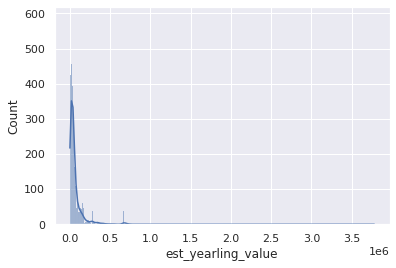

In [195]:
sns.histplot(data = data_df, x = 'est_yearling_value', kde = True) #data is clearly skewed right like most cost distributions

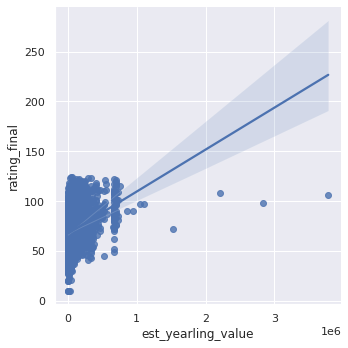

In [196]:
sns.lmplot(data = data_df, x = 'est_yearling_value', y = 'rating_final') 

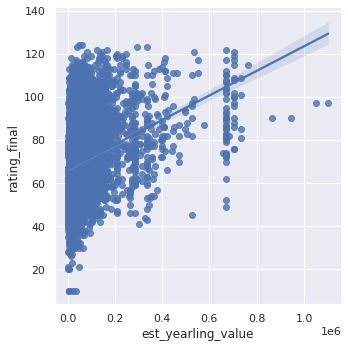

In [197]:
#we can also see in the above graph that final_sale_price_est has 4 outliers that cose more then 1,200,000. If we were to included these in the model the predicted final rating would be way over the max 130.
#should probably do a bit on testing the outliers effecting the model.
data_df = data_df.loc[data_df['est_yearling_value'] < 1200000]
sns.lmplot(data = data_df, x = 'est_yearling_value', y = 'rating_final')

In [198]:
## we can see in the above plot there is a clear correlation between rating_final and est_yealing value but the skewed est_yearlin_value column goes against the assumptions of linear regression
#will aim to transform this variable.
data_df['est_yearling_value'].min() #no negetive or 0 values. can use log to transform

840.0

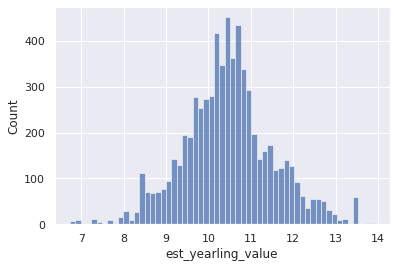

In [199]:
sns.histplot(data= np.log(data_df['est_yearling_value'])) #data is now normally distributed so I will create the new variable - log_est_yearling_value

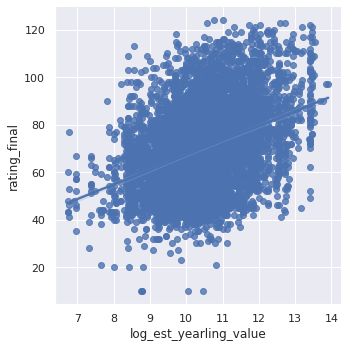

In [200]:
data_df['log_est_yearling_value'] = np.log(data_df['est_yearling_value'])
sns.lmplot(data = data_df, x = 'log_est_yearling_value', y = 'rating_final')

In [201]:
##Taken from DC
##person correltaion stats.
def pearson_r(x,y):
    ##"""Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef([x,y])

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute Pearson correlation coefficient for I. versicolor: r
data_df_no_nans = data_df.loc[~(data_df['log_est_yearling_value'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['log_est_yearling_value'], data_df_no_nans['rating_final'])

# Print the result
print(r) #there is decent correlation as much as we are going to get I suspect

0.3692679117107094


# Year/Horse Age - come back to this - not sure will i include the variable in the model or not

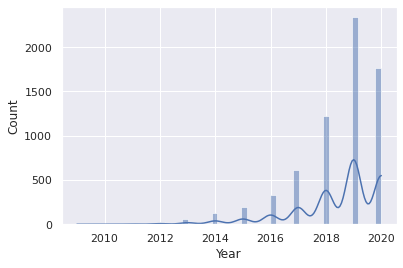

In [202]:
sns.histplot(data = data_df, x = 'Year', kde = True)

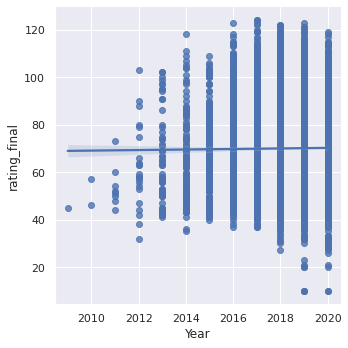

In [203]:
##look at year variable
##eda of new final_sale_price_est column
sns.lmplot(data = data_df, x = 'Year', y = 'rating_final')

In [204]:
data_df.groupby('Year')['rating_final'].count()

Year
2009       1
2010       2
2011       8
2012      23
2013      57
2014     122
2015     189
2016     333
2017     606
2018    1226
2019    2339
2020    1764
Name: rating_final, dtype: int64

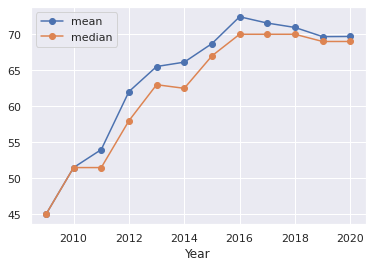

In [205]:
##looking at the above graph year looks to have no correlation or relationship with rating_final. however my gut says that isnt true. brings in domain knowledge
data_df.groupby('Year')['rating_final'].agg(['mean', 'median']).plot(marker = 'o') ##the below plot shows how there is a relationship between the mean rating by age and that the variable can be usefull in a model.
#also looking at the graph a polynomalia model may be more suitable rather then a liner model

In [206]:
data_df['horse_age'] = 2023 - data_df['Year']
data_df.head()

,Name,Year,Sex,Sire,rating_final,trainer_horses,runs,final_sale_price,sire_merge,est_yearling_value,log_est_yearling_value,horse_age
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),79.0,NaN,6.0,6160.0,Markaz,6160.000000,8.725832,5
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),49.0,14.0,5.0,4725.0,Adaay,4725.000000,8.460623,3
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),82.0,NaN,5.0,NaN,Oasis dream,44100.000000,10.694215,4
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),71.0,41.0,6.0,52500.0,Postponed,52500.000000,10.868568,4
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),42.0,35.0,4.0,NaN,Adaay,6197.666667,8.731928,4


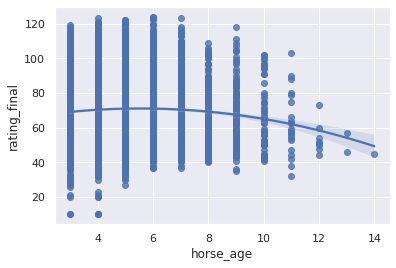

In [207]:
sns.regplot(data = data_df, x = 'horse_age', y = 'rating_final', order = 2) # an order 2 regression model fets the data better. 

In [208]:
# Compute Pearson correlation coefficient for I. versicolor: r
data_df_no_nans = data_df.loc[~(data_df['horse_age'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['horse_age'], data_df_no_nans['rating_final'])

# Print the result
print(r) #there is decent correlation now. will be the most of this project I suspect. 
#tiny correlation not neccesaryily one to include really even after the order 2

-0.01027655766164544


#Trainers Horses/Trainer Size


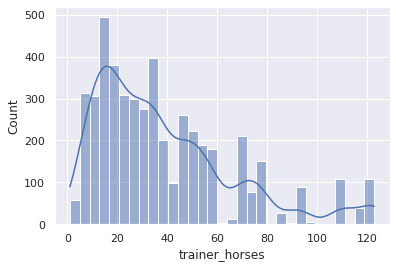

In [209]:
sns.histplot(data = data_df, x = 'trainer_horses', kde = True) #again there is signs of the data being skewed

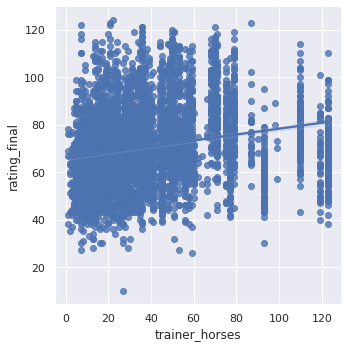

In [210]:
sns.lmplot(data = data_df, x = 'trainer_horses', y = 'rating_final') ##again there seems to be a relationship. so I will try normalize the distribution

In [211]:
## we can see in the above plot there is a clear correlation between rating_final and trainer_horses but the skewed est_yearlin_value column goes against the assumptions of linear regression
#will aim to transform this variable.
data_df['trainer_horses'].min() #no negetive or 0 values. can use log to transform

1.0

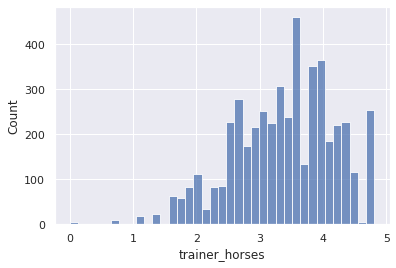

In [212]:
sns.histplot(data= np.log(data_df['trainer_horses'])) ## more normal looing

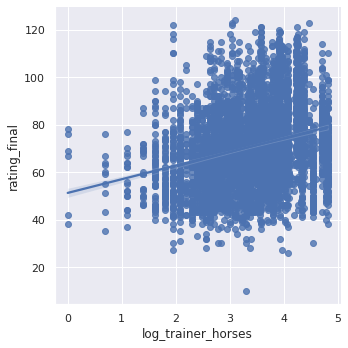

In [213]:
data_df['log_trainer_horses'] = np.log(data_df['trainer_horses'])
sns.lmplot(data = data_df, x = 'log_trainer_horses', y = 'rating_final') ##again there semms to be correlation

In [214]:
# Compute Pearson correlation coefficient
data_df_no_nans = data_df.loc[~(data_df['log_trainer_horses'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['log_trainer_horses'], data_df_no_nans['rating_final'])

# Print the result
print(r) #there is decent correlation again - positive correlation the bigger the stable the better the horse

0.2658454473774699


#Sex - Categorical Variable - Go back and have a look at DC to see how they EDA these again - Think its hypothesis testing

In [215]:
## Gelding is a castrated colt. could be best treated as one.
data_df.groupby('Sex')['rating_final'].count()

Sex
COLT        926
FILLY      2382
GELDING    3362
Name: rating_final, dtype: int64

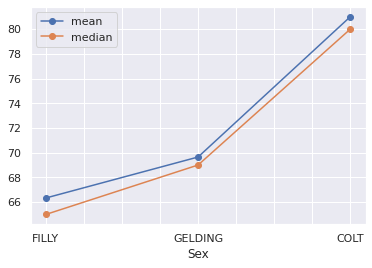

In [216]:
data_df.groupby('Sex')['rating_final'].agg(['mean', 'median']).sort_values('mean').plot(marker = 'o') ## looking at the below plot it seems clear there is a realtionship between sex and rating_final

In [217]:
##creating a dummy variable for sex
data_df[['Filly', 'Gelding']] = pd.get_dummies(data_df['Sex'], drop_first = True)
data_df.head()

,Name,Year,Sex,Sire,rating_final,trainer_horses,runs,final_sale_price,sire_merge,est_yearling_value,log_est_yearling_value,horse_age,log_trainer_horses,Filly,Gelding
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),79.0,NaN,6.0,6160.0,Markaz,6160.000000,8.725832,5,NaN,0,1
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),49.0,14.0,5.0,4725.0,Adaay,4725.000000,8.460623,3,2.639057,0,1
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),82.0,NaN,5.0,NaN,Oasis dream,44100.000000,10.694215,4,NaN,0,0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),71.0,41.0,6.0,52500.0,Postponed,52500.000000,10.868568,4,3.713572,1,0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),42.0,35.0,4.0,NaN,Adaay,6197.666667,8.731928,4,3.555348,1,0


In [218]:
data_df.head()

,Name,Year,Sex,Sire,rating_final,trainer_horses,runs,final_sale_price,sire_merge,est_yearling_value,log_est_yearling_value,horse_age,log_trainer_horses,Filly,Gelding
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),79.0,NaN,6.0,6160.0,Markaz,6160.000000,8.725832,5,NaN,0,1
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),49.0,14.0,5.0,4725.0,Adaay,4725.000000,8.460623,3,2.639057,0,1
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),82.0,NaN,5.0,NaN,Oasis dream,44100.000000,10.694215,4,NaN,0,0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),71.0,41.0,6.0,52500.0,Postponed,52500.000000,10.868568,4,3.713572,1,0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),42.0,35.0,4.0,NaN,Adaay,6197.666667,8.731928,4,3.555348,1,0


In [219]:
# # Create bee swarm plot
# sns.swarmplot(data=data, x='Sex', y='rating_final')

# # Label the axes
# plt.xlabel('Sex')
# plt.ylabel('rating_final')

# # Show the plot
# plt.show()

# Runs

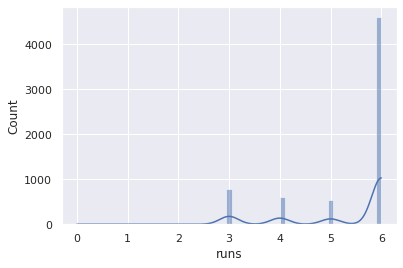

In [220]:
sns.histplot(data = data_df, x = 'runs', kde = True)

In [221]:
data_df.groupby('runs').count() # we see horses with no runs dont have a rating and can be removed

,Name,Year,Sex,Sire,rating_final,trainer_horses,final_sale_price,sire_merge,est_yearling_value,log_est_yearling_value,horse_age,log_trainer_horses,Filly,Gelding
runs,,,,,,,,,,,,,,
0.0,9,9,9,9,0,9,0,9,9,9,9,9,9,9
3.0,785,785,785,785,785,647,405,785,785,785,785,647,785,785
4.0,613,613,613,613,613,420,304,613,613,613,613,420,613,613
5.0,536,536,536,536,536,338,263,536,536,536,536,338,536,536
6.0,4602,4602,4602,4602,4601,3290,1662,4602,4602,4602,4602,3290,4602,4602


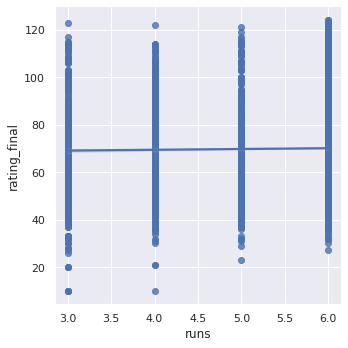

In [222]:
data_df = data_df.loc[data_df['runs'] > 0]
sns.lmplot(data = data_df, x = 'runs', y = 'rating_final') #we can see there isnt a usefull relationship between runs and rating_final. this variable wont be used in the final model.

In [223]:
data_df = data_df.drop(columns = 'runs')

# Horse Ability - Target Variable

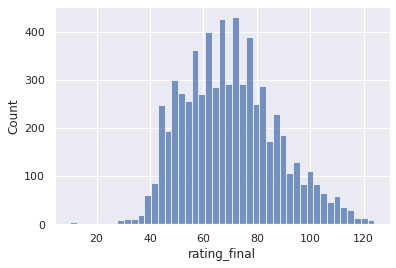

In [224]:
##EDA of rating_final variable (horse_ability)
sns.histplot(data = data_df, x = 'rating_final')
##The data is normaly distributed

In [225]:
data_df['rating_final'].min(), data['rating_final'].max() #can see there is some outliers rated 10 - this is a very low level of racing. a rating of 45 is the lowest a horse is allowed to run off of i will remove any horse rated lower then 20


(10.0, 124.0)

In [226]:
data_df = data_df.loc[data_df['rating_final'] > 20]

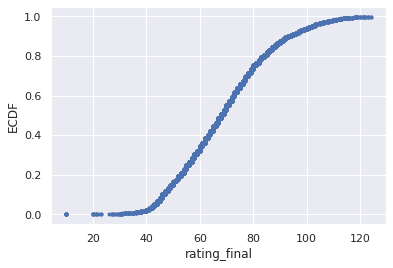

In [227]:
##ecf function taken from datacamp module
#using on rating_final
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y
  
  # Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(data['rating_final'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('rating_final')
plt.ylabel('ECDF')

# Display the plot
plt.show()

# Modeling

In [ ]:
#since i am happy with the distributions of our target and predictor variable i will fit a linear model that aims to predict horse_ability.

In [232]:
model_df = data_df[['rating_final', 'log_trainer_horses', 'log_est_yearling_value', 'Filly', 'Gelding']].dropna()
model_df.head()

,rating_final,log_trainer_horses,log_est_yearling_value,Filly,Gelding
1,49.0,2.639057,8.460623,0,1
3,71.0,3.713572,10.868568,1,0
4,42.0,3.555348,8.731928,1,0
5,43.0,4.700480,9.952278,1,0
6,80.0,2.079442,10.003333,0,1


In [234]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
y = model_df['rating_final']
X = model_df.drop(columns = 'rating_final')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))
print(reg.coef_)

Predictions: [80.48608701 69.8189076 ], Actual Values: 2442    115.0
7129     60.0
Name: rating_final, dtype: float64
[  3.91089838   5.07990498 -11.29415255  -7.50211982]


In [263]:
predictions = pd.DataFrame(y_test).merge(pd.Series(y_pred, name = 'predictions'), left_index=True, right_index=True)
predictions.head()

,rating_final,predictions
916,97.0,70.972346
568,45.0,55.644733
1299,46.0,62.947833
939,58.0,59.178862
880,82.0,57.975800


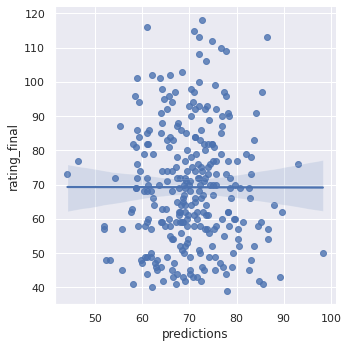

In [266]:
sns.lmplot(data = predictions, x = 'predictions', y = 'rating_final')

In [235]:
# Import mean_squared_error
from sklearn.metrics import mean_squared_error

# Compute R-squared
r_squared = reg.score(X_test, y_test)

# Compute RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: 0.20748456450142427
RMSE: 15.566753863815137


In [274]:
# Import the necessary modules
from sklearn.model_selection import KFold, cross_val_score

# Create a KFold object
kf = KFold(n_splits=6, shuffle=True, random_state=5)

reg = LinearRegression()

# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg, X, y, cv=kf)

# Print scores
print(cv_scores) #ranges from 0.189 to 0.245 based on how the model is split

[0.18893312 0.2445837  0.21237431 0.16794337 0.20326538 0.22589793]


In [276]:
# Print the mean
print(np.mean(cv_scores))

# Print the standard deviation
print(np.std(cv_scores))

# Print the 95% confidence interval
print(np.quantile(cv_scores, [0.025, 0.975]))

#we are 95% sure the models r score will lie in the range [0.17056709 0.24224798]

0.20716630106770992
0.024712222408133186
[0.17056709 0.24224798]


In [ ]:
###will prob have to bring in scaling as this was covered in the course
##boosting is another thing to bring in. 
##hyper param tuning as well 

In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')
# path = '/content/drive/My Drive/output_fee_data_2.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   fee_data.to_csv(f)

###very handy bit of code.

In [ ]:
#i think the goal here will be to predict 2023 stallion prices based on 2022 sales results, horses abilitie and 2022 fee? stud could be good too, just trying to flesh it out a bit. might get the basic sracper out if needing more data 
#we will use the 2021 sale data and whatever horses we have from 2021 to predict 2022 prices then use the findings to predict 2023 prices.  

##another goal and one to defo do is get trainer stable size using the rating csv. good use of groupby